# Full Training Pipeline Demo

This notebook demonstrates the complete end-to-end training pipeline for the AE-GMM Network Intrusion Detection System.

## Overview

This notebook covers:
1. Data loading and preprocessing
2. Feature selection using Random Forest
3. Correlation-based feature pruning
4. Autoencoder training on BENIGN samples
5. GMM training on reconstruction errors
6. Threshold computation and evaluation
7. SHAP explainer creation

## Requirements

- Full CSE-CIC-IDS2018 dataset (see `data/README.md`)
- Python 3.8+ with dependencies from `requirements.txt`

## Output

Trained models will be saved to `aegmm_nids(full_train)/AEGMM_hybrid_<timestamp>/`

Use `AEGMM_Demo.ipynb` to test the trained model.

---

In [1]:
import sys
from pathlib import Path
base = Path.cwd().parent
sys.path.append(str(base))

import shap
from utils.prepro import load_and_clean, rf_top_features, drop_correlated, make_balanced_split, scale_for_ae, get_label_encoder
from utils.visual import plot_mae_distribution, plot_gmm_score_distribution
from utils.shap_aegmm_wrappers import AEReconstructionWrapper, AEGMMWrapper
from utils.evaluation import evaluate_mae, evaluate_gmm
from models.ae_gmm_hybrid import AEGMMPipeline

c:\Users\PC\Documents\test_clone\ae_gmm_nids\ae_nids_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load the full dataset (update path to your dataset location)
df = load_and_clean('data/raw/CSECICIDS2018_improved.csv')

Cleaning data...


In [3]:
baln_df = make_balanced_split(df, ratio_normal_to_intrusions=0.317, total=286000) # Create subsampled balanced dataset because of limited resources
top = rf_top_features(baln_df, top_n=23) # Select top 23 features based on Random Forest importance
df_small, _ = drop_correlated(baln_df[top + ['Attack Type']], threshold=0.9) # Drop highly correlated features

Creating balanced dataset with total=286000 and normal:intrusions=0.317...
Attack Type
BENIGN     195338
Anormal     90662
Name: count, dtype: int64
Selecting top 23 features using Random Forest...
Top 23 features: ['FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Bwd Packet Length Max', 'Dst Port', 'FIN Flag Count', 'Fwd Seg Size Min', 'Total Length of Bwd Packet', 'ACK Flag Count', 'Fwd Act Data Pkts', 'Packet Length Max', 'Packet Length Mean', 'Bwd Segment Size Avg', 'Bwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Std', 'Flow IAT Min', 'Fwd IAT Min', 'Total Bwd packets', 'Fwd PSH Flags', 'Bwd IAT Total', 'Packet Length Std', 'Packet Length Variance', 'Total TCP Flow Time']
Dropping correlated features with threshold > 0.9...
Dropped 6 features: {'Fwd Packet Length Std', 'ACK Flag Count', 'Packet Length Std', 'Bwd Packet Length Mean', 'Total Bwd packets', 'Bwd Packet Length Std'}
Remaining features: 18


In [4]:
from sklearn.model_selection import train_test_split
train_set, test = train_test_split(df_small, test_size = 0.30, random_state = 42, stratify=df_small['Attack Type'])
train, val = train_test_split(train_set, test_size=0.2, random_state=42)
print(train['Attack Type'].value_counts())
print(val['Attack Type'].value_counts())
print(test['Attack Type'].value_counts())
scaler, X_train_norm, X_val_norm, X_test_all = scale_for_ae(train, val, test)

Attack Type
BENIGN     109282
Anormal     50878
Name: count, dtype: int64
Attack Type
BENIGN     27455
Anormal    12585
Name: count, dtype: int64
Attack Type
BENIGN     58601
Anormal    27199
Name: count, dtype: int64


In [5]:
print(X_train_norm.shape, X_val_norm.shape, X_test_all.shape)

(109282, 17) (27455, 17) (85800, 17)


In [6]:
pipe = AEGMMPipeline().fit(X_train_norm, X_val_norm, feature_names=df_small.columns[:-1], epochs=500)

Starting Autoencoder training...
Epoch 10/500 - loss: 0.0327 - val_loss: 0.0336
Epoch 20/500 - loss: 0.0259 - val_loss: 0.0269
Epoch 30/500 - loss: 0.0228 - val_loss: 0.0230
Epoch 40/500 - loss: 0.0212 - val_loss: 0.0215
Epoch 50/500 - loss: 0.0202 - val_loss: 0.0205
Epoch 60/500 - loss: 0.0195 - val_loss: 0.0197
Epoch 70/500 - loss: 0.0190 - val_loss: 0.0194
Epoch 80/500 - loss: 0.0188 - val_loss: 0.0191
Epoch 90/500 - loss: 0.0186 - val_loss: 0.0190
Epoch 100/500 - loss: 0.0186 - val_loss: 0.0189
Epoch 110/500 - loss: 0.0185 - val_loss: 0.0189
Epoch 120/500 - loss: 0.0185 - val_loss: 0.0189
Epoch 130/500 - loss: 0.0185 - val_loss: 0.0188
Epoch 140/500 - loss: 0.0184 - val_loss: 0.0188
Epoch 150/500 - loss: 0.0184 - val_loss: 0.0188
Epoch 160/500 - loss: 0.0184 - val_loss: 0.0188
Epoch 170/500 - loss: 0.0184 - val_loss: 0.0188
Epoch 180/500 - loss: 0.0184 - val_loss: 0.0188
Epoch 190/500 - loss: 0.0184 - val_loss: 0.0188
Epoch 200/500 - loss: 0.0184 - val_loss: 0.0188
Epoch 210/500 - 

In [7]:
preds_mae = pipe.predict_mae(X_test_all)

In [ ]:
Y_true=test['Attack Type']

In [9]:
rep=evaluate_mae(actual_attack_type=Y_true, mae_scores=preds_mae, threshold_mae=pipe.threshold_mae)


Classification Report (AutoEncoder Model):
              precision    recall  f1-score   support

     Anomaly       0.95      0.93      0.94     27199
      Normal       0.97      0.98      0.97     58601

    accuracy                           0.96     85800
   macro avg       0.96      0.95      0.96     85800
weighted avg       0.96      0.96      0.96     85800



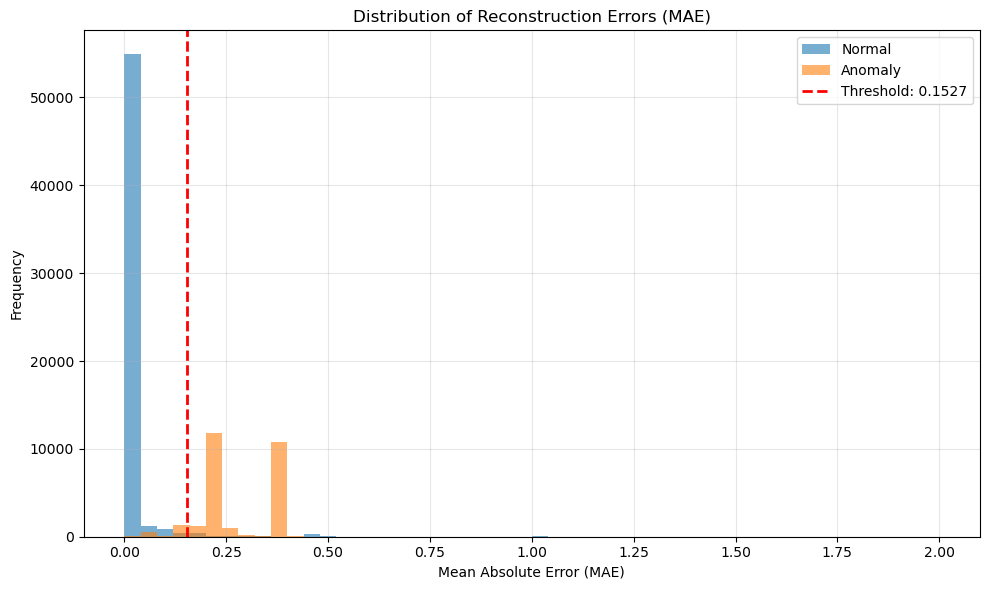

In [10]:
plot_mae_distribution(mae_errors=preds_mae, labels=Y_true, threshold_mae=pipe.threshold_mae, range_=(0,2))

In [11]:
lencode=get_label_encoder()
y_true_enc=lencode.fit_transform(Y_true) # BENIGN=1, Attack=0

In [12]:
print(test['Attack Type'].value_counts())

# Fix: Convert numpy array to pandas Series for value_counts
import pandas as pd
print(pd.Series(y_true_enc).value_counts())

Attack Type
BENIGN     58601
Anormal    27199
Name: count, dtype: int64
1    58601
0    27199
Name: count, dtype: int64


In [13]:
pred_gmm, gmm_scores = pipe.predict_gmm_scores(X_test_all)

In [14]:
gmm_rep=evaluate_gmm(true_labels_binary=y_true_enc, y_pred_binary=pred_gmm, class_names=lencode.classes_)


Classification Report (GMM Model):
              precision    recall  f1-score   support

     Anormal       0.97      0.98      0.98     27199
      BENIGN       0.99      0.99      0.99     58601

    accuracy                           0.99     85800
   macro avg       0.98      0.99      0.98     85800
weighted avg       0.99      0.99      0.99     85800



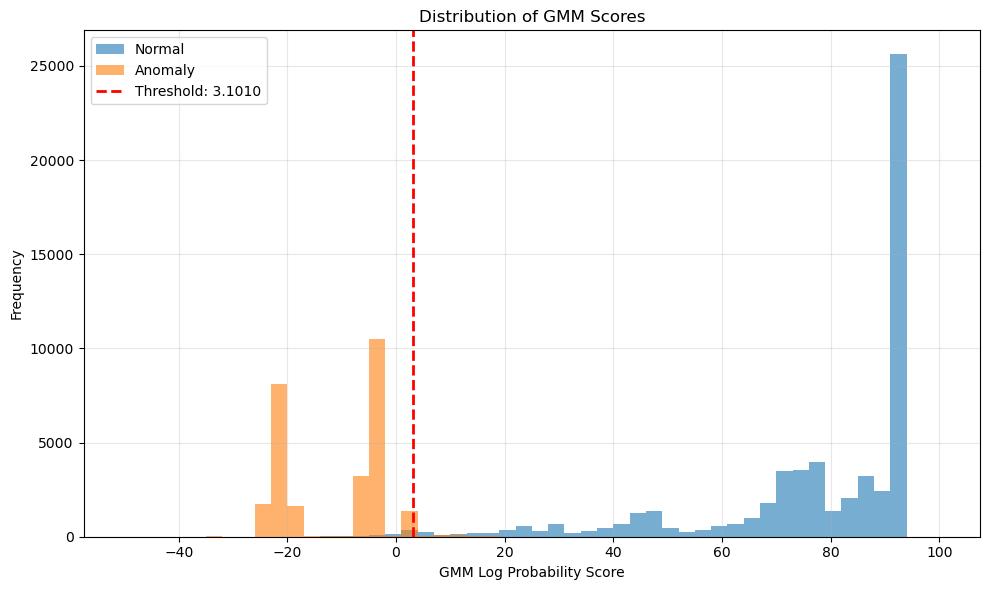

In [15]:
plot_gmm_score_distribution(gmm_scores=gmm_scores, labels=Y_true, threshold_gmm=pipe.threshold_gmm, bins=50, range_=(-50, 100))  

In [ ]:
# Build background data from existing training-normal set
# Use the original (unscaled) feature space expected by wrappers
background_data = pd.DataFrame(
    scaler.inverse_transform(X_train_norm[:1000]),
    columns=list(df_small.columns[:-1])
)

# Create lightweight explainers
ae_wrapper = AEReconstructionWrapper(
    autoencoder=pipe.autoencoder,
    scaler=scaler,
    feature_names=list(df_small.columns[:-1])
)
gmm_wrapper = AEGMMWrapper(
    autoencoder=pipe.autoencoder,
    gmm=pipe.gmm,
    scaler=scaler,
    feature_names=list(df_small.columns[:-1])
)

ae_explainer = shap.Explainer(ae_wrapper, background_data)
gmm_explainer = shap.Explainer(gmm_wrapper, background_data)


In [26]:
# Example: explain one test sample
sample_idx = 2063
sample_df = test.drop('Attack Type', axis=1).iloc[[sample_idx]]
ae_sv = ae_explainer(sample_df)
gmm_sv = gmm_explainer(sample_df)

Actual Attack Type: Anormal


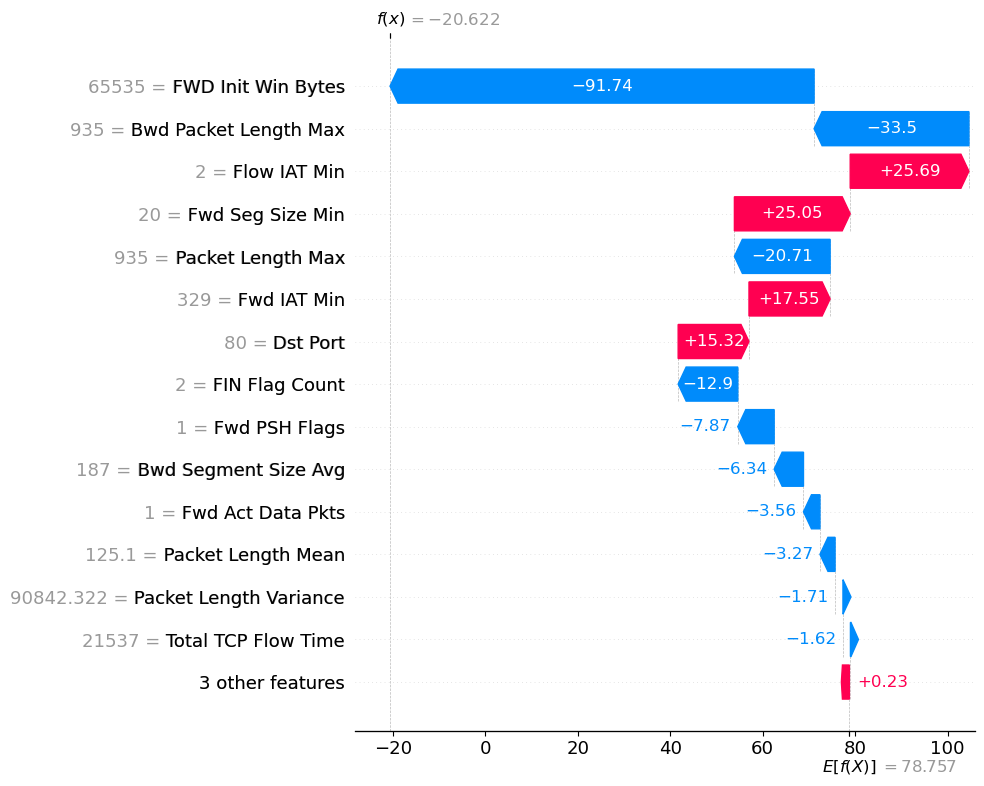

In [27]:
# Optional quick plot
print(f'Actual Attack Type: {test["Attack Type"].iloc[sample_idx]}')
shap.plots.waterfall(gmm_sv[0], max_display=15, show=True)